# Initialization and Testing File

### Initialization

In [ ]:
# Import new libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import spacy
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Save and read data files from your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To load the example data file, which is a set of abstracts of academic articles;
doc_df = pd.read_csv('/content/drive/MyDrive/2024 Spring/Text Mining/Projects/Project2/SubmissionFolder/topic_model_train_wo_label.csv')

### Testing Data File

In [ ]:
# Check the first 3 rows and add another column with the number of words per Abstract
doc_df['ABSTRACT_word_count'] = doc_df['ABSTRACT'].apply(lambda x: len(str(x).split(" ")))
doc_df.head(3)

,ID,TITLE,ABSTRACT,ABSTRACT_word_count
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,242
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,72
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,93


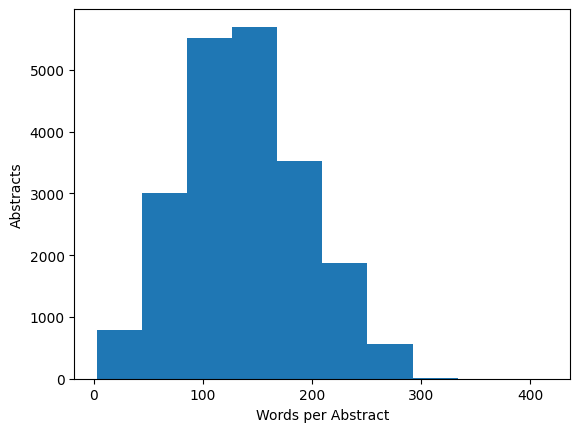

In [ ]:
# Show a Histogram of the word count per abstract
plt.hist(doc_df['ABSTRACT_word_count'])
plt.xlabel("Words per Abstract")
plt.ylabel("Abstracts")
plt.show()

# Making A Preprocessor (For LDA. May have to be changed for sentence embedding)

In [ ]:
# By looking at some of the abstracts, we can decide if there are certain patterns that we should take out with the preprocessor

# for i in range(12): # Use to see first 12 Abstracts
for i in range(1): # Use to see first Abstract
    abstract = doc_df['ABSTRACT'].iloc[i]
    print(f'Abstract {i+1}:')
    print(abstract, "\n" + "-"*80, "\n")

Abstract 1:
  Predictive models allow subject-specific inference when analyzing disease
related alterations in neuroimaging data. Given a subject's data, inference can
be made at two levels: global, i.e. identifiying condition presence for the
subject, and local, i.e. detecting condition effect on each individual
measurement extracted from the subject's data. While global inference is widely
used, local inference, which can be used to form subject-specific effect maps,
is rarely used because existing models often yield noisy detections composed of
dispersed isolated islands. In this article, we propose a reconstruction
method, named RSM, to improve subject-specific detections of predictive
modeling approaches and in particular, binary classifiers. RSM specifically
aims to reduce noise due to sampling error associated with using a finite
sample of examples to train classifiers. The proposed method is a wrapper-type
algorithm that can be used with different binary classifiers in a diagno

In [ ]:
spacy_lemma = spacy.load("en_core_web_sm")
def my_preprocessor(text):
  """
  Parameters:
    text: (str)

  Changes:
    Converts text to lowercase
    Removed Markdown code
    Removed numbers
    Removed stop words (english and spanish)
    Removed parentheses (and everything inside them)
    Removed punctuation
    Lemmatizes

  """

  # Makes text lowercase
  text_lower = text.lower()

  # adds flag in texts as period for sentence embedding
  # period is replaced with periodflag
  # if sentence_embedding:
    # text_lower = text.replace('. ', 'periodflag ')

  # Remove parentheses and anything inside them
  text_paren = re.sub(r'\(.*?\)', '', text_lower)

  # Remove numbers
  text_num = re.sub(r'\d+', '', text_paren)

  # Remove markdown / LaTeX code (starts with '\' or '$' or contain underscores)
  text_clean = re.sub(r'[\$\\]\S+|\b\w*_\w*\b', '', text_num)

  # Split text into words (also gets rid of punctuation)
  tokens = RegexpTokenizer(r'\w+').tokenize(text_clean)

  # Define stop words
  stop_words = set(stopwords.words('english')) | set(stopwords.words('spanish'))

  # Removes stopwords
  stopunct_tokens = []
  for token in tokens:
    if token not in stop_words:
      stopunct_tokens.append(token)

  # Combines text for and processes with SpaCy
  text_processed_0 = ' '.join(stopunct_tokens)
  text_spacy = spacy_lemma(text_processed_0)

  # Lemmatization
  pos_tags = {'NOUN', 'ADJ', 'VERB', 'ADV'}
  lemma_tokens = []
  for token in text_spacy:
    if token.pos_ in pos_tags:
      lemma_tokens.append(token.lemma_)

  common_words = [
      'approach',
      'consider',
      'define',
      'different',
      'feature',
      'first',
      'general',
      'however',
      'known',
      'method',
      'network',
      'number',
      'obtain',
      'present',
      'problem',
      'propose',
      'provide',
      'result'
  ]

  # Keep words > 4 letters and rid of common words with little meaning
  final_tokens = []
  for token in lemma_tokens:
    if len(token) > 5 and token not in common_words:
    # if len(token) > 5:
      final_tokens.append(token)

  # Make one string again
  text_processed = ' '.join(final_tokens)

  return text_processed

In [ ]:
# Test the first abstract
abstract = doc_df['ABSTRACT'].iloc[1]
print(my_preprocessor(abstract))
print(abstract)


rotation invariance translation invariance recognition architecture convolutional neural cyclic convolutional achieve rotation invariance symbol position orientation symbol achieve detection purpose multiple overlap target architecture achieve invariance
  Rotation invariance and translation invariance have great values in image
recognition tasks. In this paper, we bring a new architecture in convolutional
neural network (CNN) named cyclic convolutional layer to achieve rotation
invariance in 2-D symbol recognition. We can also get the position and
orientation of the 2-D symbol by the network to achieve detection purpose for
multiple non-overlap target. Last but not least, this architecture can achieve
one-shot learning in some cases using those invariance.



# LDA Topic Modeling


### Initialization

In [ ]:
# Import new libraries
!pip install pyLDAvis
!pip install gensim
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model as sklearnvis
import seaborn as sns
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

### LDA Function from SKLearn

###### Vectorize text

In [ ]:
# Use TF-IDF vectorizer to turn abstracts into vectors (may take 6+ minutes)
my_vectorizer = TfidfVectorizer(preprocessor=my_preprocessor, max_features = 7500)
abstract_vectorized = my_vectorizer.fit_transform(doc_df['ABSTRACT'])

NameError: name 'TfidfVectorizer' is not defined

In [ ]:
# Define the LDA Model
# After running 10+ topics, using 4 seems realistic because it always separates the data

lda_model = LatentDirichletAllocation(n_components= 4, # Number of topics
                                    doc_topic_prior = None, # Default is 1/n_documents
                                    topic_word_prior = None, # Default is 1/n_documents
                                    learning_method='batch',  # 'batch' runs slower, but generalizes. 'online' updates iteratively
                                    random_state= 10,
                                    max_iter=10) # The number of epoches for the training (how many times you wlll go through the entire corpus)

In [ ]:
# Fit LDA Model to TF-IDF Vectors (will take 1+ minutes)
lda_top=lda_model.fit_transform(abstract_vectorized)

##### Explore output

In [ ]:
# Print out the top 10 word tokens in each topic
# The output (tokens and their relevance for each topic) of the LDA model can be accessed through either or lad_top or lda_model.components_
vocab = my_vectorizer.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
    terms_comp = zip(vocab, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i+1)+": ")
    for t in sorted_terms:
        print(t[0],end=" ")
    print("\n")

Topic 1: 
system learning neural performance information dataset training design framework analysis 

Topic 2: 
distribution estimator matrix sample function random algorithm parameter estimate stochastic 

Topic 3: 
temperature magnetic energy particle quantum effect transition system electron interaction 

Topic 4: 
equation function solution operator theory manifold condition system galaxy boundary 



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20972 samples in 0.016s...
[t-SNE] Computed neighbors for 20972 samples in 0.560s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20972
[t-SNE] Computed conditional probabilities for sample 2000 / 20972
[t-SNE] Computed conditional probabilities for sample 3000 / 20972
[t-SNE] Computed conditional probabilities for sample 4000 / 20972
[t-SNE] Computed conditional probabilities for sample 5000 / 20972
[t-SNE] Computed conditional probabilities for sample 6000 / 20972
[t-SNE] Computed conditional probabilities for sample 7000 / 20972
[t-SNE] Computed conditional probabilities for sample 8000 / 20972
[t-SNE] Computed conditional probabilities for sample 9000 / 20972
[t-SNE] Computed conditional probabilities for sample 10000 / 20972
[t-SNE] Computed conditional probabilities for sample 11000 / 20972
[t-SNE] Computed conditional probabilities for sample 12000 / 20972
[t-SNE] Computed conditional probabilities for sam

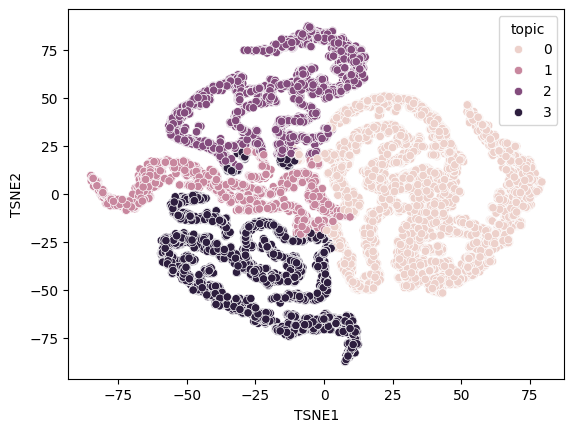

In [ ]:
# Visualize the results using TSNE (May take 2+ minutes)
TSNE_model = TSNE(n_components=2, verbose=1, random_state=10, angle=.99, init='pca')
tsne_lda = TSNE_model.fit_transform(lda_top)
TSNE_df = pd.DataFrame(tsne_lda, columns=['TSNE1', 'TSNE2'])
TSNE_df['topic'] = np.argmax(lda_top, axis=1)
sns.scatterplot(x="TSNE1", y="TSNE2", hue="topic", data=TSNE_df)
plt.show()

In [ ]:
pyLDAvis.enable_notebook()
vis_data = sklearnvis.prepare(lda_model, abstract_vectorized, my_vectorizer)
pyLDAvis.display(vis_data)

### LDA with Gensim

##### Vectorize Text

In [ ]:
id2word = corpora.Dictionary([[word] for word in my_vectorizer.get_feature_names_out()])

# Converts preprocessed text to Gensim's corpus format
def gensim_prep(preprocessed_texts):
    tokens = [text.split() for text in preprocessed_texts]
    corpus = [id2word.doc2bow(token) for token in tokens]
    return id2word, corpus, preprocessed_texts, tokens

preprocessed_texts = [" ".join(text.split()) for text in doc_df['ABSTRACT']]
# id2word, corpus, doc_processed, doc_tokens = gensim_prep(preprocessed_texts)
id2word, corpus, doc_preprocessed, doc_tokens = gensim_prep(preprocessed_texts)

In [ ]:
# Build Model (May take 2+ minutes)
Num_of_Topics = 4
lda_model_gensim = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=Num_of_Topics,
    random_state=10,
    update_every=1,
    chunksize=250,
    passes=30,
    iterations = 40,
    alpha='auto',
    eta='auto',
    minimum_probability=0.0001,
    per_word_topics=True
)

##### Explore Output

In [ ]:
# Print the topics with their top 10 words
topics_gensim = lda_model_gensim.print_topics(num_words=10)
for topic in topics_gensim:
    print(topic)

(0, '0.017*"learning" + 0.012*"proposed" + 0.010*"performance" + 0.010*"information" + 0.009*"neural" + 0.007*"training" + 0.007*"system" + 0.006*"demonstrate" + 0.006*"framework" + 0.005*"analysis"')
(1, '0.015*"algorithm" + 0.012*"function" + 0.012*"linear" + 0.009*"random" + 0.008*"optimal" + 0.008*"distribution" + 0.008*"solution" + 0.007*"finite" + 0.007*"matrix" + 0.007*"stochastic"')
(2, '0.009*"boundary" + 0.009*"compact" + 0.008*"observed" + 0.006*"evolution" + 0.006*"spectrum" + 0.006*"surface" + 0.006*"cluster" + 0.006*"stellar" + 0.006*"emission" + 0.006*"formation"')
(3, '0.015*"energy" + 0.014*"quantum" + 0.013*"magnetic" + 0.010*"system" + 0.008*"transition" + 0.008*"temperature" + 0.007*"topological" + 0.006*"optical" + 0.006*"structure" + 0.006*"critical"')


In [ ]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=doc_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda*100, '%')

Coherence Score:  46.63202263179903 %


In [ ]:
# Visualize LDA
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model_gensim, corpus, id2word)
pyLDAvis.display(vis_data)

# Sentence Embedding + Clustering

### Initialization

In [ ]:
# Import new libraries
!pip install -U sentence-transformers
import scipy.cluster.hierarchy as sch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Doc2Vec, Hierarchical Clustering via SKLearn, and Output via TSNE

In [ ]:
# Process all the text (May take 6+ minutes)
doc_processed = [my_preprocessor(text) for text in doc_df['ABSTRACT']]

In [ ]:
# (May take 2+ minutes)
tagged_docs = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(doc_processed)]

# Make and train the model
model = Doc2Vec(vector_size=40,
                min_count=3, # filter out the infrequent tokens, whose term frequency is lower than min_count
                epochs=30)


model.build_vocab(tagged_docs)
model.train(tagged_docs,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [ ]:
# Get document vectors (May take 2+ minutes)
doc_vectors = [model.infer_vector(word_tokenize(doc)) for doc in doc_processed]

# Cluster the documents
num_of_clusters = 4

my_clustering = AgglomerativeClustering(n_clusters=num_of_clusters,  linkage='ward')
my_clustering.fit_predict(doc_vectors)
cluster_assignment = my_clustering.labels_

In [ ]:
# Display Results
results_df = pd.DataFrame({'ABSTRACT': doc_df['ABSTRACT']})

cluster_assignment_series = pd.Series(cluster_assignment, name='Cluster')
results_df = pd.DataFrame({
    'ABSTRACT': doc_df['ABSTRACT'],
    'PROCESSED_TEXT': doc_processed,
    'Cluster': cluster_assignment
})
results_df.head()


,ABSTRACT,PROCESSED_TEXT,Cluster
0,Predictive models allow subject-specific inf...,predictive subject specific inference analyze ...,0
1,Rotation invariance and translation invarian...,rotation invariance translation invariance rec...,0
2,We introduce and develop the notion of spher...,introduce develop notion spherical polyharmoni...,0
3,The stochastic Landau--Lifshitz--Gilbert (LL...,stochastic couple maxwell equation describe cr...,0
4,Fourier-transform infra-red (FTIR) spectra o...,transform sample specie explore influence prep...,1


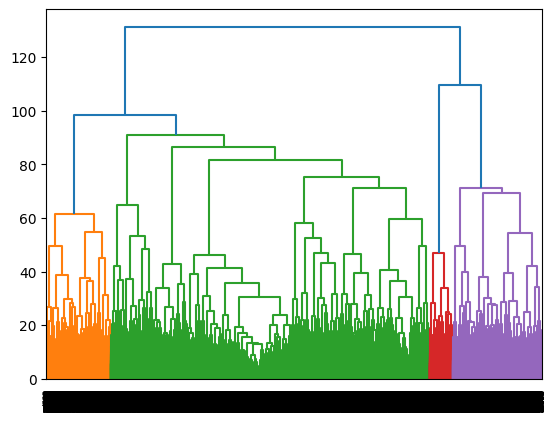

In [ ]:
# Display Dendrogram (May take 2+ minutes)
sch.dendrogram(sch.linkage(doc_vectors, method='ward'))
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20972 samples in 0.001s...
[t-SNE] Computed neighbors for 20972 samples in 4.445s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20972
[t-SNE] Computed conditional probabilities for sample 2000 / 20972
[t-SNE] Computed conditional probabilities for sample 3000 / 20972
[t-SNE] Computed conditional probabilities for sample 4000 / 20972
[t-SNE] Computed conditional probabilities for sample 5000 / 20972
[t-SNE] Computed conditional probabilities for sample 6000 / 20972
[t-SNE] Computed conditional probabilities for sample 7000 / 20972
[t-SNE] Computed conditional probabilities for sample 8000 / 20972
[t-SNE] Computed conditional probabilities for sample 9000 / 20972
[t-SNE] Computed conditional probabilities for sample 10000 / 20972
[t-SNE] Computed conditional probabilities for sample 11000 / 20972
[t-SNE] Computed conditional probabilities for sample 12000 / 20972
[t-SNE] Computed conditional probabilities for sam

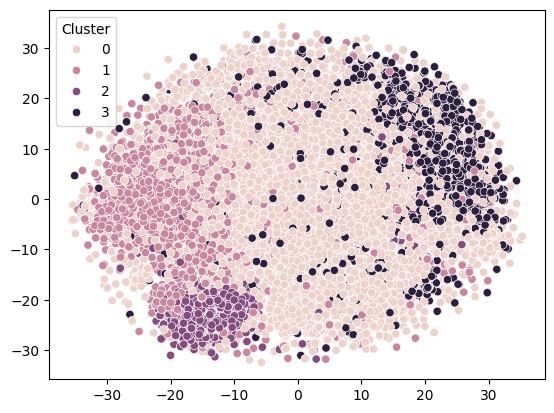

In [ ]:
# Convert vectors into numpy array for tsne (May take 4+ minutes)
embeddings = np.array(doc_vectors)
TSNE_model = TSNE(n_components=2, verbose=1, random_state=10, angle=.85, init='pca', perplexity=30)
reduced_embeddings = TSNE_model.fit_transform(embeddings)

# Display Results
TSNE_df = pd.DataFrame(reduced_embeddings, columns=['TSNE1', 'TSNE2'])
TSNE_df['topic'] = results_df['Cluster']
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=results_df['Cluster'], data=TSNE_df)
plt.show()

### SBERT (all-MiniLM-L6-v2), Hierarchical Clustering SKLearn, and Output via Dendrogram and TSNE

In [ ]:
# sbert_model = SentenceTransformer("allenai-specter")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# May take 16+ min
# Use sbert model to embed, using doc_processed from Doc2Vec test
embeddings = sbert_model.encode(doc_processed, batch_size = 128, show_progress_bar=True)

Batches:   0%|          | 0/164 [00:00<?, ?it/s]

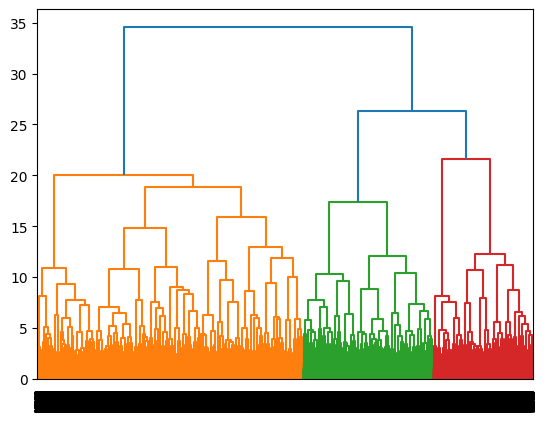

In [ ]:
# Display Dendrogram (May take 2+ minutes)
sch.dendrogram(sch.linkage(embeddings, method='ward'))
plt.show()

In [ ]:
# May take 2+ minutes
embeddings = StandardScaler().fit_transform(embeddings)
num_of_clusters = 4
my_clustering = AgglomerativeClustering(n_clusters=num_of_clusters,  linkage='ward')
my_clustering.fit_predict(embeddings)
cluster_assignment = my_clustering.labels_

In [ ]:
results_df = pd.DataFrame({'ABSTRACT': doc_df['ABSTRACT']})

cluster_assignment_series = pd.Series(cluster_assignment, name='Cluster')
results_df = pd.DataFrame({
    'ABSTRACT': doc_df['ABSTRACT'],
    'PROCESSED_TEXT': doc_processed,
    'Cluster': cluster_assignment
})
results_df.head()

,ABSTRACT,PROCESSED_TEXT,Cluster
0,Predictive models allow subject-specific inf...,predictive subject specific inference analyze ...,0
1,Rotation invariance and translation invarian...,rotation invariance translation invariance rec...,0
2,We introduce and develop the notion of spher...,introduce develop notion spherical polyharmoni...,2
3,The stochastic Landau--Lifshitz--Gilbert (LL...,stochastic couple maxwell equation describe cr...,2
4,Fourier-transform infra-red (FTIR) spectra o...,transform sample specie explore influence prep...,0


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20972 samples in 0.005s...
[t-SNE] Computed neighbors for 20972 samples in 16.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20972
[t-SNE] Computed conditional probabilities for sample 2000 / 20972
[t-SNE] Computed conditional probabilities for sample 3000 / 20972
[t-SNE] Computed conditional probabilities for sample 4000 / 20972
[t-SNE] Computed conditional probabilities for sample 5000 / 20972
[t-SNE] Computed conditional probabilities for sample 6000 / 20972
[t-SNE] Computed conditional probabilities for sample 7000 / 20972
[t-SNE] Computed conditional probabilities for sample 8000 / 20972
[t-SNE] Computed conditional probabilities for sample 9000 / 20972
[t-SNE] Computed conditional probabilities for sample 10000 / 20972
[t-SNE] Computed conditional probabilities for sample 11000 / 20972
[t-SNE] Computed conditional probabilities for sample 12000 / 20972
[t-SNE] Computed conditional probabilities for sa

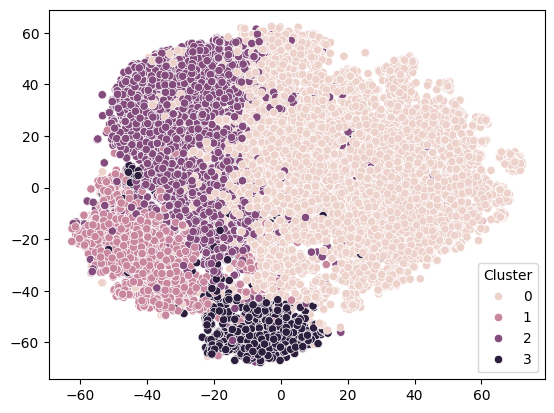

In [ ]:
# Convert vectors into numpy array for tsne (May take up to 3+ minutes)
embeddings = np.array(embeddings)
TSNE_model = TSNE(n_components=2, verbose=1, random_state=10, angle=.85, init='pca', perplexity=30)
reduced_embeddings = TSNE_model.fit_transform(embeddings)

# Display Results
TSNE_df = pd.DataFrame(reduced_embeddings, columns=['TSNE1', 'TSNE2'])
TSNE_df['topic'] = results_df['Cluster']
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=results_df['Cluster'], data=TSNE_df)
plt.show()